In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import os
import time
import random

random.seed(2025) #settings all seeds. used Claude to help.
torch.manual_seed(2025)
np.random.seed(2025)
torch.cuda.manual_seed(2025)
torch.cuda.manual_seed_all(2025)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '2025'


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
best_acc = 0
start_epoch = 0

print('==> Preparing data..') #https://github.com/kuangliu/pytorch-cifar
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(0.2)  # Add dropout layer

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)  # dropout
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, width_multiplier=1.0, num_classes=10): #ADDED a width_multiplier so that there would be a fraction of the original amount of channels and parameters set by https://github.com/kuangliu/pytorch-cifar. We used 0.665 to get just under 5 million parameters
        super(ResNet, self).__init__()
        self.width_multiplier = width_multiplier
        self.in_planes = int(64 * width_multiplier)

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, int(64 * width_multiplier), num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, int(128 * width_multiplier), num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, int(256 * width_multiplier), num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, int(512 * width_multiplier), num_blocks[3], stride=2)
        self.linear = nn.Linear(int(512 * width_multiplier) * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add final dropout layer


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  #apply dropout
        out = self.linear(out)
        return out



print('==> Building model..')
net = ResNet(BasicBlock, [2, 2, 2, 2], width_multiplier=0.665)  # Using half width to reduce parameters



net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if os.path.isdir('checkpoint'): #checkpoint functionality taken from #https://github.com/kuangliu/pytorch-cifar
    try:
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load('./checkpoint/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
    except:
        print('No checkpoint found or error loading checkpoint')

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) #added label_smoothing to reduce overconfidence and overfitting

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-5) #adjusted lr and weight_decay in testing. changed optimizer from SGD to ADAMW

num_epochs = 100 #max number of epochs, early stopping is implemented so the model may stop before this

scheduler = torch.optim.lr_scheduler.OneCycleLR( #changed scheduler from CosineAnnealingLR to OneCycleLR
    optimizer, max_lr=0.01, total_steps=num_epochs*len(trainloader),
    pct_start=0.3, anneal_strategy='cos'
)

if device == 'cpu': #print out the summary to get the details of the model and how many parameters there are (ensured to be < 5M)
    summary(net, (3, 32, 32))
else:
    net = net.to(device)
    summary(net, (3, 32, 32), device=device)


Using device: cuda
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Resuming from checkpoint..
No checkpoint found or error loading checkpoint
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,876
       BatchNorm2d-4           [-1, 42, 32, 32]              84
            Conv2d-5           [-1, 42, 32, 32]          15,876
       BatchNorm2d-6           [-1, 42, 32, 32]              84
           Dropout-7           [-1, 42, 32, 32]               0
        BasicBlock-8           [-1, 42, 32, 32]               0
            Conv2d-9           [-1, 42, 32, 32]          15,876
      BatchNorm2d-10           [-1, 42, 32, 32]              84
           Conv

<ipython-input-13-9f0408660890>:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/ckpt.pth')


As can be seen above, this model's architecture gives it 4.9M features, putting us under the 5M feature threshold.

In [14]:


#taken from https://github.com/kuangliu/pytorch-cifar
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(trainloader):
            print(f'Train Epoch: {epoch} [{batch_idx+1}/{len(trainloader)}] '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.3f}% ({correct}/{total})')

    return train_loss/len(trainloader), 100.*correct/total


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Test Loss: {test_loss/len(testloader):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')


    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

    return test_loss/len(testloader), acc

def testModel():
    net.eval()
    predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
    return predictions


train_losses = [] #store the test and train loss and acc for the graphs after training.
train_accs = []
test_losses = []
test_accs = []
epoch_list = []

#these are used for early stopping. if early_stopping_counter = 10, we halt training. This means the model did not improve for 10 epochs (the epochs do not have to be consecutive due to the random nature of these models)
patience = 10
early_stop_counter = 0
best_test_loss = float('inf')

for epoch in range(start_epoch, start_epoch + num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    #store these for later
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    epoch_list.append(epoch)


    if test_loss < best_test_loss: #does the early stopping if necessary
        best_test_loss = test_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

checkpoint = torch.load('./checkpoint/ckpt.pth') #we only save to ckpt.pth if an epochs test accuracy > previous best test accuracy so we can just load ckpt to get our best model
net.load_state_dict(checkpoint['net'])


test_loss, test_acc = test(0)
print(f'Best test accuracy: {best_acc:.2f}%')
print(f'Final test accuracy: {test_acc:.2f}%')




Epoch: 0
Train Epoch: 0 [100/391] Loss: 2.044 | Acc: 28.398% (3635/12800)
Train Epoch: 0 [200/391] Loss: 1.906 | Acc: 34.363% (8797/25600)
Train Epoch: 0 [300/391] Loss: 1.814 | Acc: 38.477% (14775/38400)
Train Epoch: 0 [391/391] Loss: 1.754 | Acc: 41.422% (20711/50000)
Test Loss: 1.547 | Acc: 53.910% (5391/10000)
Saving..

Epoch: 1
Train Epoch: 1 [100/391] Loss: 1.466 | Acc: 55.477% (7101/12800)
Train Epoch: 1 [200/391] Loss: 1.429 | Acc: 57.691% (14769/25600)
Train Epoch: 1 [300/391] Loss: 1.401 | Acc: 59.268% (22759/38400)
Train Epoch: 1 [391/391] Loss: 1.379 | Acc: 60.446% (30223/50000)
Test Loss: 1.363 | Acc: 62.220% (6222/10000)
Saving..

Epoch: 2
Train Epoch: 2 [100/391] Loss: 1.249 | Acc: 66.750% (8544/12800)
Train Epoch: 2 [200/391] Loss: 1.238 | Acc: 67.527% (17287/25600)
Train Epoch: 2 [300/391] Loss: 1.223 | Acc: 68.320% (26235/38400)
Train Epoch: 2 [391/391] Loss: 1.211 | Acc: 68.920% (34460/50000)
Test Loss: 1.238 | Acc: 68.550% (6855/10000)
Saving..

Epoch: 3
Train Epoc

<ipython-input-14-c332643c1d6d>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/ckpt.pth') #we only save to ckpt.pth if an epochs te

Test Loss: 0.683 | Acc: 93.090% (9309/10000)
Best test accuracy: 93.09%
Final test accuracy: 93.09%


Metrics plot saved as training_metrics.png


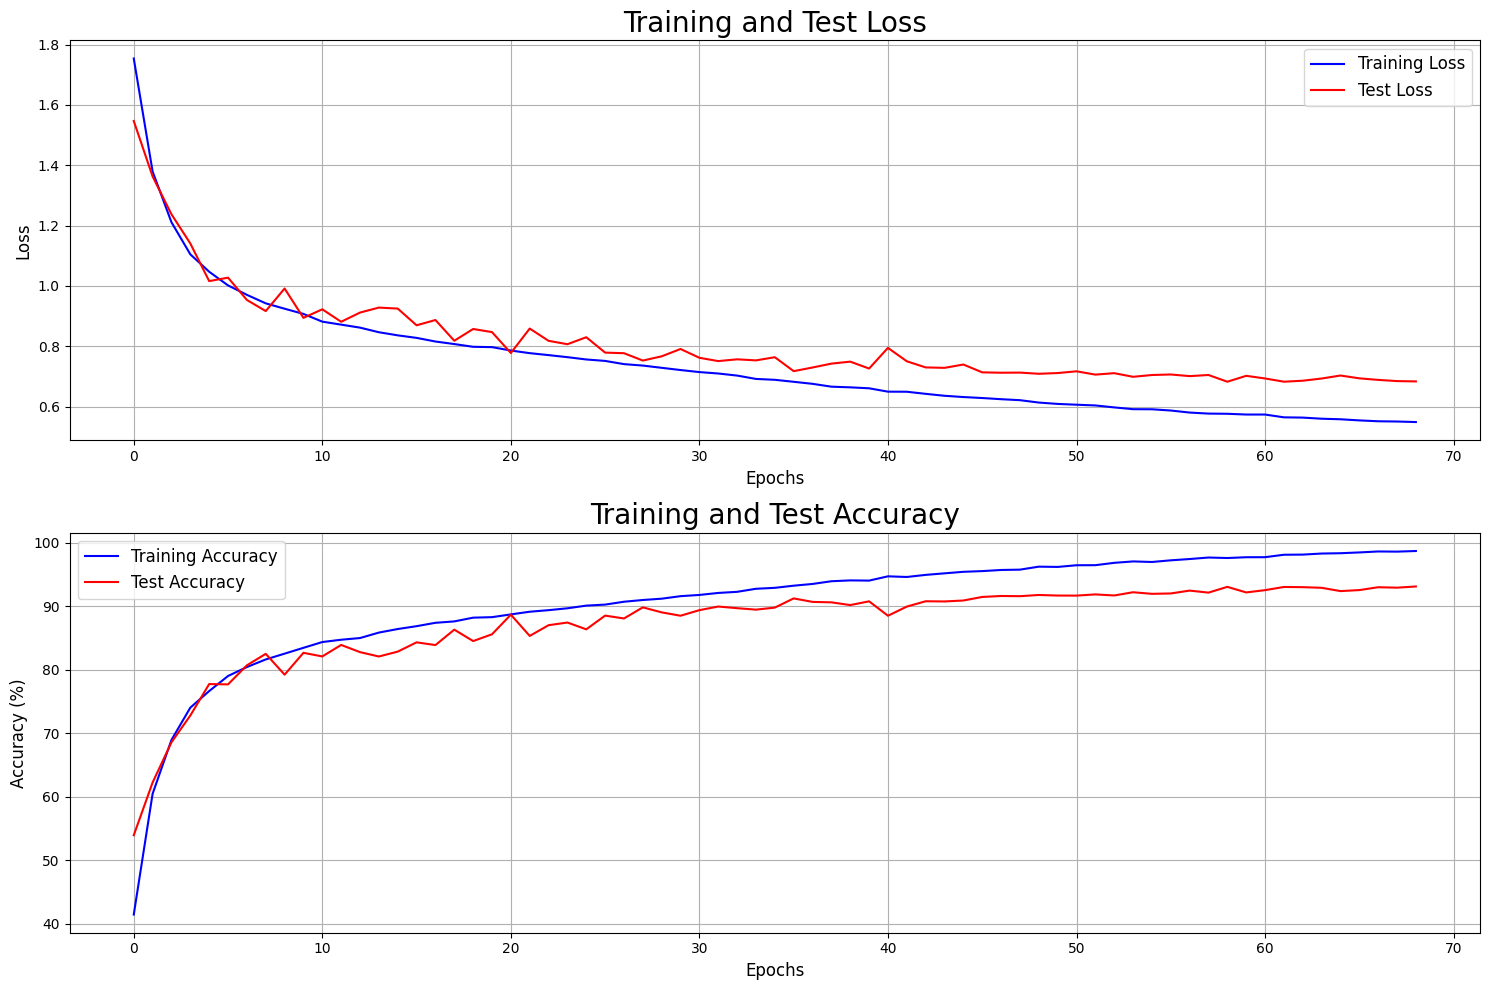

In [15]:
def plot_metrics(train_losses, train_accs, test_losses, test_accs, epochs): #utilized Claude to assist in making graphs visually appealling.
    plt.figure(figsize=(15, 10))

    # plot training & test loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Training and Test Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    # plot training & test accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Test Accuracy')
    plt.title('Training and Test Accuracy', fontsize=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    print('Metrics plot saved as training_metrics.png')
    plt.show()

  # plot the training and testing metrics
plot_metrics(train_losses, train_accs, test_losses, test_accs, epoch_list)

In [18]:
try:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    test = unpickle("cifar_test_nolabel.pkl")
    test_images = test[b'data'].astype(np.float32) / 255.0 #normalize

    test_dataset = [(transform_test(img)) for img in test_images]

    unlabeled_testloader = torch.utils.data.DataLoader( #testloader for the pkl's unlabeled dataset for the submission
        test_dataset, batch_size=100, shuffle=False, num_workers=2)

    net.eval()

    predictions = []
    with torch.no_grad():
        for batch_idx, inputs in enumerate(unlabeled_testloader):
            inputs = inputs.to(device)  #feed it to the model
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy()) #get outputs

    submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved.")
except Exception as e:
    print("Couldn't find the unlabeled test file. Skipping submission generation.")
    print(e)

Submission file saved.
